In [1]:
import duckdb
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import yellowbrick
import folium 

# UTMB races notebook 
## Roadmap: 
1. EDA (quick and dirty look at the data to understand it)
2. map with all the locations of the races with:
    - the distances offered 
    - the dates 
    - the styles 
3. Cluster analysis to see what races are similar to each other 
    --> Maybe use this to make a recommendation system for people where people can input their preferences such as time of year, distances, style, etc.
4. add a layer for explainability to the cluster analysis and the recommendation system. 
5. (optional) Maybe make a second DAG to go into each race and retrieve more data. 

In [8]:
#load the data from duckdb
conn = duckdb.connect('../data/utmb_db.duckdb')
table = data_cleaned = conn.sql("select * from UTMB").df()
print(table)

                                   name  date_confirmed              country  \
0                     Nice Côte d'Azur             True               France   
1                     Arc Of Attrition             True       United Kingdom   
2     Tarawera Ultra-Trail New Zealand             True          New Zealand   
3              Amazean Jungle Thailand            False             Thailand   
4                    Valhöll Argentina             True            Argentina   
5                  Chianti Ultra Trail             True                Italy   
6   Desert Rats Trail Running Festival            False        United States   
7                           Istria 100             True              Croatia   
8                Ultra-Trail Mount Yun             True                China   
9                   Grand Raid Ventoux             True               France   
10              Canyons Endurance Runs             True        United States   
11              Quindío Trail Colombia  

In [111]:
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 85 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   name                        50 non-null     object        
 1   date_confirmed              50 non-null     bool          
 2   country                     50 non-null     object        
 3   city                        50 non-null     object        
 4   image                       50 non-null     object        
 5   link                        50 non-null     object        
 6   distance_5                  50 non-null     bool          
 7   distance_10                 50 non-null     bool          
 8   distance_15                 50 non-null     bool          
 9   distance_20                 50 non-null     bool          
 10  distance_25                 50 non-null     bool          
 11  distance_30                 50 non-null     bool          
 

In [13]:
table.describe()

,multidays,start_day,end_day,month,year,duration,latitude,longitude
count,0.0,28.000000,28.000000,50.000000,50.0,28.000000,50.000000,50.000000
mean,NaN,15.607143,17.642857,6.980000,2025.0,2.142857,28.755822,3.224303
std,NaN,7.460212,7.533699,2.729207,0.0,1.532712,26.979241,81.260921
min,NaN,2.000000,4.000000,1.000000,2025.0,1.000000,-38.138149,-179.283333
25%,NaN,11.000000,13.000000,5.000000,2025.0,1.000000,23.494097,-54.962090
50%,NaN,16.000000,18.500000,7.000000,2025.0,2.000000,41.628905,7.294028
75%,NaN,21.500000,23.500000,9.000000,2025.0,2.000000,46.446471,34.272637
max,NaN,26.000000,29.000000,12.000000,2025.0,9.000000,56.426789,176.252922


## Dashboard:
- A dashboard with basic information regarding the UTMB World Series events.  
- A map with all the locations of the events.


In [47]:
number_of_events =table.shape[0]
number_of_countries = table['country'].nunique()
number_of_cities = table['city'].nunique()

print(f'Over the year there are {number_of_events} events in {number_of_cities} cities from {number_of_countries} different countries.')


Over the year there are 50 events in 50 cities from 29 different countries.


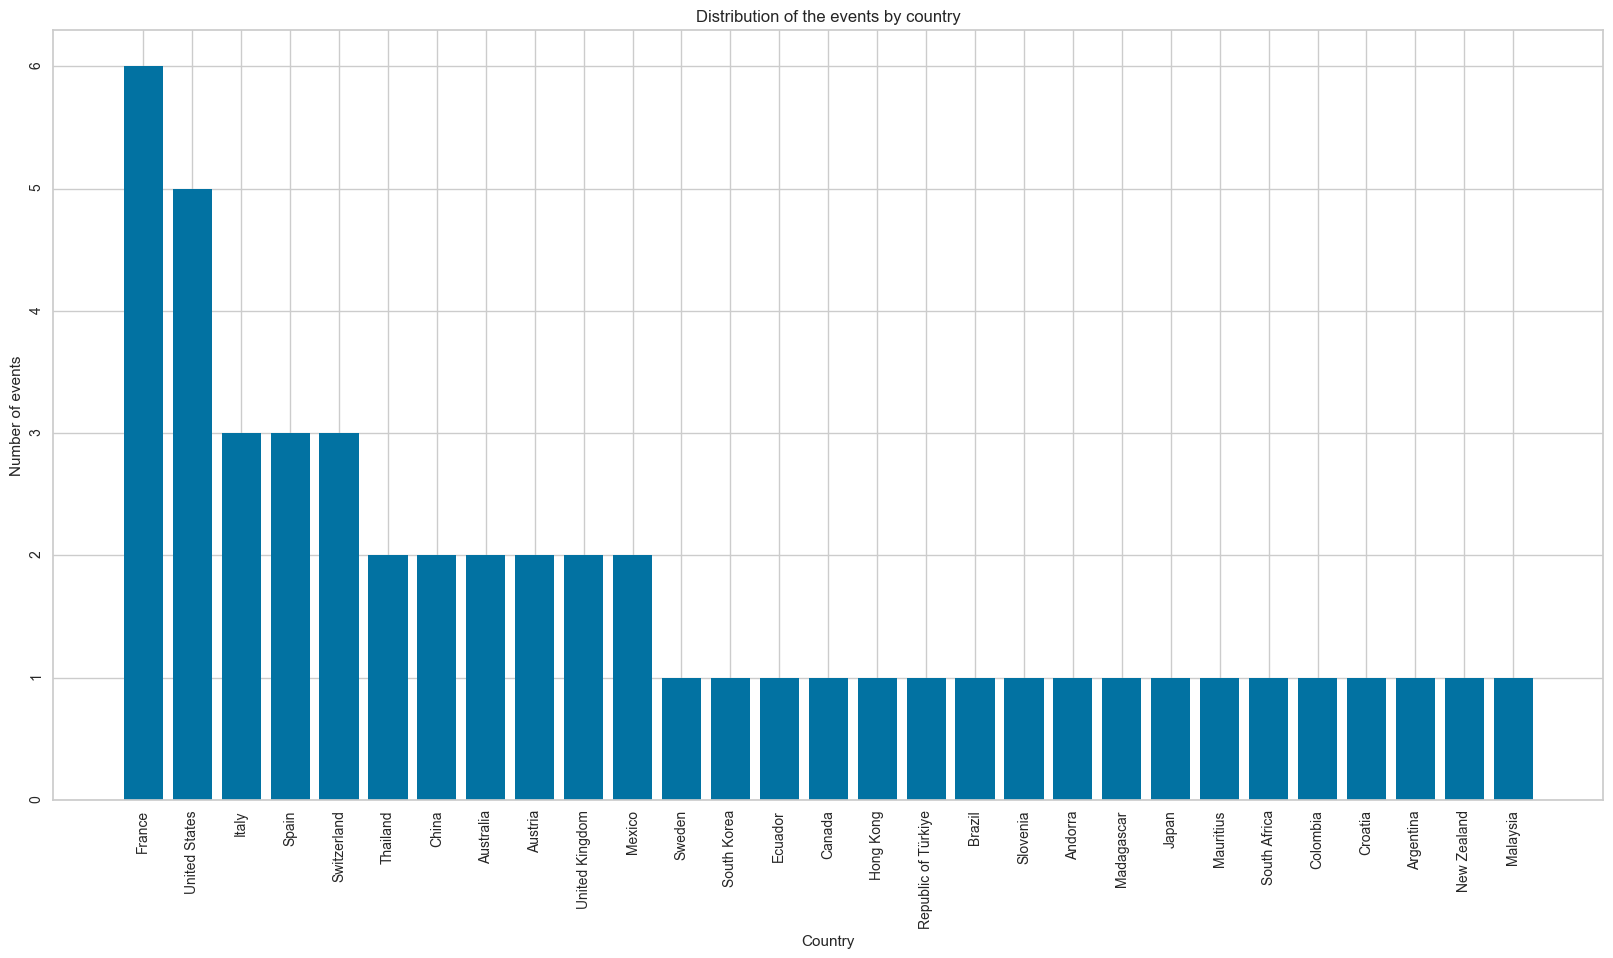

In [29]:
#distribution of the events by country
country_distribution = table['country'].value_counts()
country_distribution
fig =plt.figure(figsize=(20,10))
plt.bar(country_distribution.index, country_distribution.values)
fig.axes[0].tick_params(labelrotation=90)
fig.axes[0].set_title('Distribution of the events by country')
fig.axes[0].set_xlabel('Country')
fig.axes[0].set_ylabel('Number of events')
plt.show()

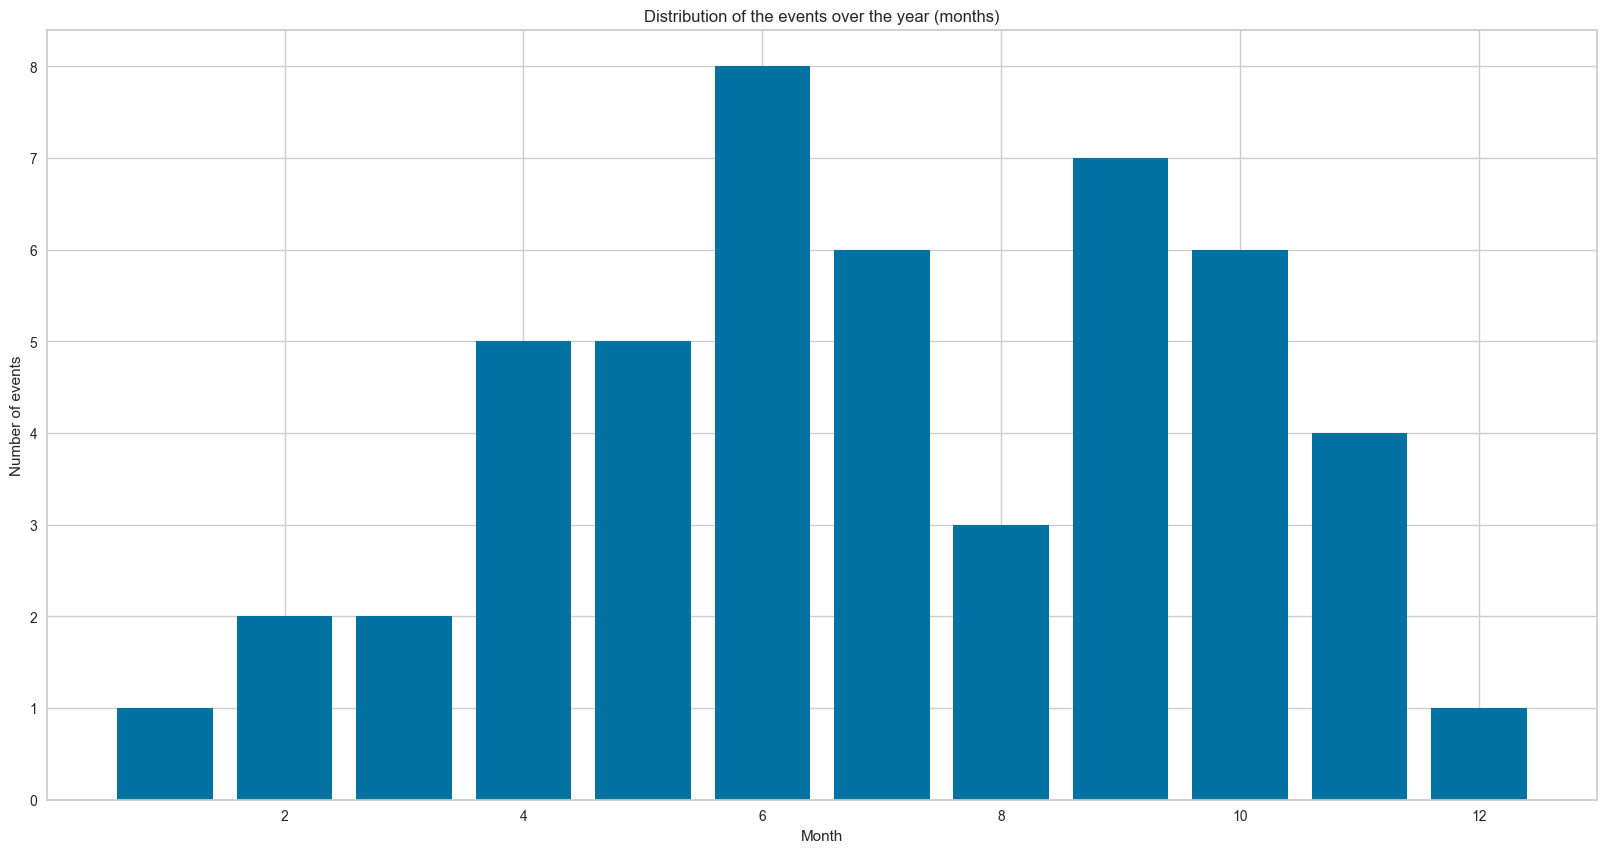

In [45]:
#distribution of the events over the year (months)
month_distribution = table['month'].value_counts()
fig =plt.figure(figsize=(20,10))	
plt.bar(month_distribution.index, month_distribution.values)
fig.axes[0].set_title('Distribution of the events over the year (months)')
fig.axes[0].set_xlabel('Month')
fig.axes[0].set_ylabel('Number of events')
plt.show()

In [142]:
# start_day as int 
table['start_day'] = table['start_day'].replace(np.nan, 0)
table['start_day'] = table['start_day'].astype(int)
#month as int
table['month'] = table['month'].astype(int)
#year as int
table['year'] = table['year'].astype(int)
#end_day as int
table['end_day'] = table['end_day'].replace(np.nan, 0)
table['end_day'] = table['end_day'].astype(int)
#duration as remove nan
table['duration'] = table['duration'].replace(np.nan, 0)

In [163]:
table['multidays'].value_counts().count()

np.int64(0)

In [176]:
table.columns

Index(['name', 'date_confirmed', 'country', 'city', 'image', 'link',
       'distance_5', 'distance_10', 'distance_15', 'distance_20',
       'distance_25', 'distance_30', 'distance_35', 'distance_40',
       'distance_45', 'distance_50', 'distance_55', 'distance_60',
       'distance_65', 'distance_70', 'distance_75', 'distance_80',
       'distance_85', 'distance_90', 'distance_95', 'distance_100',
       'distance_105', 'distance_110', 'distance_115', 'distance_120',
       'distance_125', 'distance_130', 'distance_135', 'distance_140',
       'distance_145', 'distance_150', 'distance_155', 'distance_160',
       'distance_165', 'distance_170', 'distance_175', 'distance_250',
       'distance_300', 'style_', 'style_Altitude', 'style_Asateam',
       'style_Autonomy', 'style_Capitals/largecities', 'style_Cascade',
       'style_Castles', 'style_Children's&Juniors', 'style_CitytoCity',
       'style_Cliffs', 'style_Cross-border', 'style_Culture&History',
       'style_Duo', 'style_For

In [124]:
# Function to retrieve offered distances for a row
def get_offered_distances(row):
    # Filter columns that start with 'distance_'
    distance_columns = [col for col in row.index if col.startswith('distance_')]
    
    # Extract distances where the flag is True
    offered_distances = [col.replace('distance_', '') for col in distance_columns if row[col]]
    
    # Join the distances into a comma-separated string
    return ', '.join(offered_distances)

In [219]:
import wordninja
def split_into_words_wordninja(input_string):
    replacements = {
        'S': 'Sand',
        'U': 'UTMB'
    }
    remove = ['and','TMB' ]
    # Use wordninja to split the string
    words = wordninja.split(input_string)
    words = [replacements.get(word, word) for word in words]
    words = [word for word in words if word not in remove]
    return ' '.join(words)


In [220]:
import wordninja
# Function to retrieve offered distances for a row
def get_offered_styles(row):
    # Filter columns that start with 'style_'
    style_columns = [col for col in row.index if col.startswith('style_')]
    
    # Extract distances where the flag is True
    offered_styles = [col.replace('style_', '') for col in style_columns if row[col]]
    offered_styles = [split_into_words_wordninja(style) for style in offered_styles]
    # Join the distances into a comma-separated string
    return ', '.join(offered_styles)

In [221]:
from datetime import datetime, timedelta
s = folium.Map(location=[table['latitude'].mean(), table['longitude'].mean()], zoom_start=2)
for i in range(table.shape[0]):
    offered_distances = get_offered_distances(table.iloc[i])
    offered_styles = get_offered_styles(table.iloc[i])
    name = table['name'][i]
    image = table['image'][i]
    country = table['country'][i]
    city = table['city'][i]
    style = get_offered_styles(table.iloc[i])
    if table['start_day'][i] != 0:
        start_date = datetime(table['year'][i], table['month'][i], table['start_day'][i]).strftime('%Y-%m-%d')
    else:
        start_date = datetime(table['year'][i], table['month'][i],1).strftime('%Y-%m')
        start_date+=' day to be defined'
    if table['duration'][i]>1:
        duration = table['duration'][i]
        if table['end_day'][i] != 0:
            end_date= datetime(table['year'][i], table['month'][i], table['end_day'][i]).strftime('%Y-%m-%d')
        else:
            pass
        dates_str=f'<p style="margin: 0; font-size: 14px; color: #555;"><strong>Dates:</strong> From {start_date} to {end_date} ({int(duration)} days)</p'
    else:
        dates_str=f'<p style="margin: 0; font-size: 14px; color: #555;"><strong>Date:</strong> {start_date}</p>'

    html = f"""
    <div style="font-family: Arial, sans-serif; width: 400px;">
        <h3 style="margin: 0; padding: 0; font-size: 18px; color: #333;">{name}</h3>
        <hr style="margin: 5px 0; border: 0; border-top: 1px solid #ccc;">
        <img src="{image}" alt="image" style="width: 60%; height: auto; border-radius: 5px; margin-bottom: 10px;">
        <p style="margin: 0; font-size: 14px; color: #555;"><strong>Distances:</strong> {offered_distances} km</p>
        <p style="margin: 0; font-size: 14px; color: #555;"><strong>Type of race:</strong> {offered_styles}</p> 
        <p style="margin: 0; font-size: 14px; color: #555;"><strong>Location:</strong> {city} ({country})</p> 
        {dates_str}
    </div>
    """ 
    folium.Marker([table['latitude'][i], table['longitude'][i]], popup=html).add_to(s)

In [222]:
s